<a href="https://colab.research.google.com/github/raheelam98/langgraph_guru/blob/main/llm_ai_agents/3_reflexion_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**Reflection is a prompting strategy** used to improve the quality and success rate of agents and similar AI systems

[Reflection Agents - blog](https://blog.langchain.dev/reflection-agents/)

[Reflection Agents - Youtube](https://www.youtube.com/watch?v=v5ymBTXNqtk&t=299s)

[Reflexion - GitHub](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/reflexion/reflexion.ipynb)


### Reflexion Agent

Agentic Search Tool

Things Use

*   OpenAI GPT / ollama3.2 /
*   Function Calling
*   Travily Search Engine
*   LangSmit


Work Flow
- first_responder_chain
- Structured Output
- OutputParsers(Pydantic)
- Function Calling

In [2]:
# packages:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai langchain   python-dotenv

In [3]:
# API keys set up
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "reflexion_agent"


In [4]:
import os
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')

In [5]:
# llm
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

In [89]:
llm.invoke("hello")

AIMessage(content='Hello there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-ecc391bb-971f-4c75-aba1-e87ecebaf755-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

#### Requirements

Install the requirements to use the [Tavily Search Engine](https://python.langchain.com/docs/integrations/tools/tavily_search/), and set your [TAVILY_API_KEY](https://tavily.com/).

In [6]:
 # packages
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [7]:
# API keys set up
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

In [42]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("Rain expected in Karachi this week")


[{'url': 'https://www.thenews.com.pk/latest/1220109-karachi-weather-update-pmd-forecasts-more-rain-in-next-24-hours',
  'content': 'Opinion Newspost Editorial Instep Money Matters YOU US TNS Mostly "moderate rain with thundershowers" expected to hit Karachi this week, says PMD chief meteorologist KARACHI: The Pakistan Meteorological Department (PMD) Thursday said the city will witness cloudy skies, drizzle and light rain in the next 24 hours after experiencing light rain early in the morning today. He said that "mostly moderate rain with thundershowers" is expected in Karachi and "there may be heavy rain at some areas". The National Disaster Management Authority (NDMA) has warned of urban flooding, ahead of heavy rains which are expected to hit various parts of the country in coming days.'},
 {'url': 'https://weather.com/en-PK/weather/tenday/l/1635c698505df4d47cc0a87bdf5b697154d56b59b2efd7f8b6d12d2457476fb0',
  'content': 'Be prepared with the most accurate 10-day forecast for Karachi,

**ToolMessage**



In [8]:
# tool_classes.py

#reflex_agent/tool_executor.py
# take input AI Message on search quary get the real time result

from typing import List

from pydantic import BaseModel, Field

class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")


class AnswerQuestion(BaseModel):
    """Answer the question."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: List[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )


# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question."""

    references: List[str] = Field(
        description="Citations motivating your updated answer."
    )

tools_class = [Reflection, AnswerQuestion, ReviseAnswer]





In [9]:
# chain.py

from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv

load_dotenv()
import datetime

from langchain_core.output_parsers import JsonOutputToolsParser, PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

#from schemas import AnswerQuestion, ReviseAnswer


# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key =  os.environ["GEMINI_API_KEY"])

parser = JsonOutputToolsParser(return_id=True)

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert researcher.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        ("system", "Answer the user's question above using the required format."),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)


first_responder = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer."
) | llm.bind_tools(tools=[AnswerQuestion], tool_choice="AnswerQuestion")
validator = PydanticToolsParser(tools=[AnswerQuestion])


revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1]  https://example.com
            - [2]  https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""


revisor = actor_prompt_template.partial(
    first_instruction=revise_instructions
) | llm.bind_tools(tools=[ReviseAnswer], tool_choice="ReviseAnswer")




In [10]:
# tool_executor.py
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.tools import StructuredTool
from langgraph.prebuilt import ToolNode

# from cool_classes import AnswerQuestion, ReviseAnswer

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)


def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)



In [11]:
# main.py

from typing import List

from dotenv import load_dotenv

from langchain_core.messages import BaseMessage, ToolMessage
from langgraph.graph import END, MessageGraph

# from chains import first_responder, revisor
# from tool_executor import tool_node

# Load environment variables
load_dotenv()

MAX_ITERATIONS = 2

builder = MessageGraph()
builder.add_node("draft", first_responder)
builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor)
builder.add_edge("draft", "execute_tools")
builder.add_edge("execute_tools", "revise")


def event_loop(state: List[BaseMessage]) -> str:
    count_tool_visits = sum(isinstance(item, ToolMessage) for item in state)
    num_iterations = count_tool_visits
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


builder.add_conditional_edges("revise", event_loop)
builder.set_entry_point("draft")
graph = builder.compile()



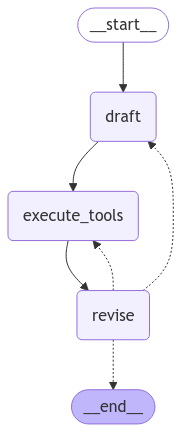

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

**check to invoke graph**

In [62]:
# from langchain_core.messages import HumanMessage, SystemMessage


# def preprocess_messages(messages):
#     """Convert all SystemMessage objects to HumanMessage for compatibility."""
#     return [
#         HumanMessage(content=msg.content)
#         if isinstance(msg, SystemMessage)
#         else msg
#         for msg in messages
#     ]


# # Input as a HumanMessage
# input_message = HumanMessage(
#     content="Write about AI-Powered SOC / autonomous SOC problem domain. "
#     "List startups that do that and raised capital."
# )

# # Preprocess messages (if graph adds SystemMessage objects)
# preprocessed_input = preprocess_messages([input_message])

# # Invoke the graph
# res = graph.invoke(preprocessed_input)

# # Access and print the results
# if res and res[-1].tool_calls:
#     # Print the answer from the tool calls
#     print(res[-1].tool_calls[0]["args"]["answer"])
# else:
#     print("No tool calls or responses found.")

# # Print the full result for debugging
# print(res)


In [61]:
# res = graph.invoke(
#     "Write about AI-Powered SOC / autonomous soc  problem domain, list startups that do that and raised capital."
# )
# print(res[-1].tool_calls[0]["args"]["answer"])
# print(res)

**check**